<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Practical 3b - Overfitting and Underfitting</h2><h3>AY2020/21 Semester</h3></th>
    </tr>
</table>

In [1]:
from tensorflow import keras
print('keras: ', keras.__version__)

keras:  2.2.4-tf


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Objectives
After completing this practical exercise, students should be able to:
1. [Understand how to prevent overfitting in Neural Networks](#over)
2. [Exercise - Develop your own model and try to avoid overfitting](#exc)

### Load Data

Note: in this notebook we will be using the IMDB test set as our validation set. It doesn't matter in this context.

Let's prepare the data using the code from Practical 2:

In [3]:
from tensorflow.keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

## 1. How to prevent overfitting in Neural Networks <a id='over' />

### 1.1 Reducing the network's size 

Our original network was as such:

In [4]:
from tensorflow.keras import models
from tensorflow.keras import layers

original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

Now let's try to replace it with this smaller network:

In [5]:
smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])

In [6]:
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=512,
                                   validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 4s 145us/sample - loss: 0.4500 - acc: 0.8268 - val_loss: 0.3355 - val_acc: 0.8819
Epoch 2/20
25000/25000 [==============================] - 2s 78us/sample - loss: 0.2608 - acc: 0.9088 - val_loss: 0.2841 - val_acc: 0.8890
Epoch 3/20
25000/25000 [==============================] - 2s 78us/sample - loss: 0.2014 - acc: 0.9293 - val_loss: 0.2852 - val_acc: 0.8870
Epoch 4/20
25000/25000 [==============================] - 2s 77us/sample - loss: 0.1670 - acc: 0.9415 - val_loss: 0.2934 - val_acc: 0.8838
Epoch 5/20
25000/25000 [==============================] - 2s 78us/sample - loss: 0.1448 - acc: 0.9494 - val_loss: 0.3200 - val_acc: 0.8776
Epoch 6/20
25000/25000 [==============================] - 2s 79us/sample - loss: 0.1257 - acc: 0.9561 - val_loss: 0.3814 - val_acc: 0.8612
Epoch 7/20
25000/25000 [==============================] - 2s 79us/sample - loss: 0.1117 - acc: 0.9613 - val_loss: 0

In [7]:
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512,
                                       validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 3s 109us/sample - loss: 0.5992 - acc: 0.7374 - val_loss: 0.5259 - val_acc: 0.8147
Epoch 2/20
25000/25000 [==============================] - 2s 77us/sample - loss: 0.4438 - acc: 0.8807 - val_loss: 0.4109 - val_acc: 0.8770
Epoch 3/20
25000/25000 [==============================] - 2s 77us/sample - loss: 0.3370 - acc: 0.9067 - val_loss: 0.3415 - val_acc: 0.8859
Epoch 4/20
25000/25000 [==============================] - 2s 77us/sample - loss: 0.2702 - acc: 0.9176 - val_loss: 0.3048 - val_acc: 0.8894
Epoch 5/20
25000/25000 [==============================] - 2s 77us/sample - loss: 0.2275 - acc: 0.9272 - val_loss: 0.2871 - val_acc: 0.8912
Epoch 6/20
25000/25000 [==============================] - 2s 79us/sample - loss: 0.1988 - acc: 0.9345 - val_loss: 0.2896 - val_acc: 0.8846
Epoch 7/20
25000/25000 [==============================] - 2s 78us/sample - loss: 0.1775 - acc: 0.9412 - val_loss: 0

In [8]:
epochs = range(1, 21)
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']

Here's a comparison of the validation losses of the original network and the smaller network. The dots are the validation loss values of 
the smaller network, and the crosses are the initial network (remember: a lower validation loss signals a better model).

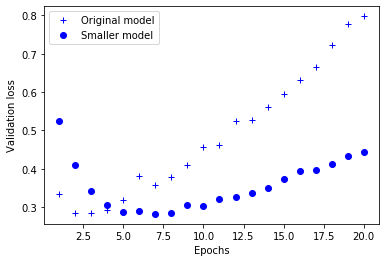

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# b+ is for "blue cross"
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
# "bo" is for "blue dot"
plt.plot(epochs, smaller_model_val_loss, 'bo', label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


As you can see, the smaller network starts overfitting later than the reference one (after 6 epochs rather than 4) and its performance 
degrades much more slowly once it starts overfitting.

Now, for kicks, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [10]:
bigger_model = models.Sequential()
bigger_model.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
bigger_model.add(layers.Dense(512, activation='relu'))
bigger_model.add(layers.Dense(1, activation='sigmoid'))

bigger_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['acc'])

In [11]:
bigger_model_hist = bigger_model.fit(x_train, y_train,
                                     epochs=20,
                                     batch_size=512,
                                     validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 3s 136us/sample - loss: 0.4540 - acc: 0.8048 - val_loss: 0.3156 - val_acc: 0.8700
Epoch 2/20
25000/25000 [==============================] - 3s 111us/sample - loss: 0.2152 - acc: 0.9151 - val_loss: 0.2851 - val_acc: 0.8861
Epoch 3/20
25000/25000 [==============================] - 3s 113us/sample - loss: 0.1211 - acc: 0.9566 - val_loss: 0.3766 - val_acc: 0.8795
Epoch 4/20
25000/25000 [==============================] - 3s 112us/sample - loss: 0.0619 - acc: 0.9812 - val_loss: 0.4692 - val_acc: 0.8771
Epoch 5/20
25000/25000 [==============================] - 3s 112us/sample - loss: 0.0967 - acc: 0.9860 - val_loss: 0.4731 - val_acc: 0.8826
Epoch 6/20
25000/25000 [==============================] - 3s 112us/sample - loss: 0.0021 - acc: 0.9998 - val_loss: 0.6848 - val_acc: 0.8807
Epoch 7/20
25000/25000 [==============================] - 3s 112us/sample - loss: 0.0064 - acc: 0.9982 - val_l

Here's how the bigger network fares compared to the reference one. The dots are the validation loss values of the bigger network, and the 
crosses are the initial network.

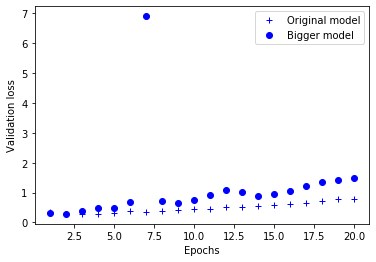

In [12]:
bigger_model_val_loss = bigger_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_val_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


The bigger network starts overfitting almost right away, after just one epoch, and overfits much more severely. Its validation loss is also 
more noisy.

Meanwhile, here are the training losses for our two networks:

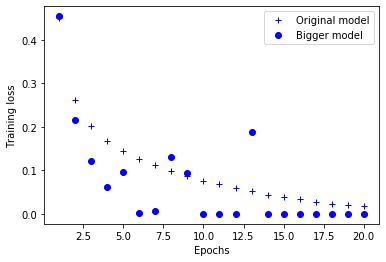

In [13]:
original_train_loss = original_hist.history['loss']
bigger_model_train_loss = bigger_model_hist.history['loss']

plt.plot(epochs, original_train_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_train_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()

plt.show()

As you can see, the bigger network gets its training loss near zero very quickly. The more capacity the network has, the quicker it will be 
able to model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large 
difference between the training and validation loss).

### 1.2 Adding weight regularization

In Keras, weight regularization is added by passing _weight regularizer instances_ to layers as keyword arguments. Let's add L2 weight regularization to our movie review classification network:

In [14]:
from tensorflow.keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value` to the total loss of the network. 

Here's the impact of our L2 regularization penalty:

In [16]:
l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 3s 114us/sample - loss: 0.5023 - acc: 0.8191 - val_loss: 0.3942 - val_acc: 0.8735
Epoch 2/20
25000/25000 [==============================] - 2s 80us/sample - loss: 0.3250 - acc: 0.9037 - val_loss: 0.3452 - val_acc: 0.8825
Epoch 3/20
25000/25000 [==============================] - 2s 80us/sample - loss: 0.2769 - acc: 0.9199 - val_loss: 0.3621 - val_acc: 0.8723
Epoch 4/20
25000/25000 [==============================] - 2s 78us/sample - loss: 0.2576 - acc: 0.9256 - val_loss: 0.3332 - val_acc: 0.8868
Epoch 5/20
25000/25000 [==============================] - 2s 79us/sample - loss: 0.2444 - acc: 0.9312 - val_loss: 0.3426 - val_acc: 0.8835
Epoch 6/20
25000/25000 [==============================] - 2s 79us/sample - loss: 0.2370 - acc: 0.9337 - val_loss: 0.3449 - val_acc: 0.8836
Epoch 7/20
25000/25000 [==============================] - 2s 79us/sample - loss: 0.2274 - acc: 0.9378 - val_loss: 0

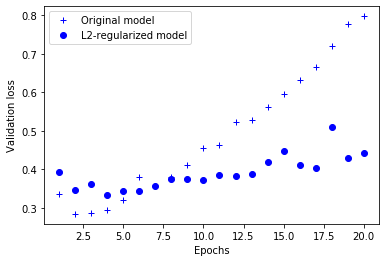

In [17]:
l2_model_val_loss = l2_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l2_model_val_loss, 'bo', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()



As you can see, the model with L2 regularization (dots) has become much more resistant to overfitting than the reference model (crosses), 
even though both models have the same number of parameters.

As alternatives to L2 regularization, you could use one of the following Keras weight regularizers:

In [18]:
from tensorflow.keras import regularizers

# L1 regularization
regularizers.l1(0.001)

# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001)

### 1.3 Adding dropout

In Keras you can introduce dropout in a network via the `Dropout` layer, which gets applied to the output of layer right before it. Let's add two `Dropout` layers in our IMDB network to see how well they do at reducing overfitting:

In [19]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

In [20]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 3s 108us/sample - loss: 0.6254 - acc: 0.6417 - val_loss: 0.5041 - val_acc: 0.8556
Epoch 2/20
25000/25000 [==============================] - 2s 81us/sample - loss: 0.4907 - acc: 0.7758 - val_loss: 0.3836 - val_acc: 0.8763
Epoch 3/20
25000/25000 [==============================] - 2s 80us/sample - loss: 0.4006 - acc: 0.8413 - val_loss: 0.3155 - val_acc: 0.8864
Epoch 4/20
25000/25000 [==============================] - 2s 82us/sample - loss: 0.3400 - acc: 0.8725 - val_loss: 0.2850 - val_acc: 0.8880
Epoch 5/20
25000/25000 [==============================] - 2s 79us/sample - loss: 0.2921 - acc: 0.8930 - val_loss: 0.2807 - val_acc: 0.8868
Epoch 6/20
25000/25000 [==============================] - 2s 81us/sample - loss: 0.2624 - acc: 0.9050 - val_loss: 0.2860 - val_acc: 0.8887
Epoch 7/20
25000/25000 [==============================] - 2s 80us/sample - loss: 0.2370 - acc: 0.9162 - val_loss: 0

Let's plot the results:

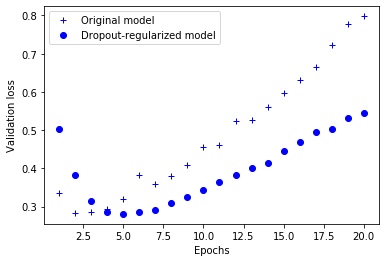

In [21]:
dpt_model_val_loss = dpt_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


Again, a clear improvement over the reference network.

To recap: here the most common ways to prevent overfitting in neural networks:

* Getting more training data.
* Reducing the capacity of the network.
* Adding weight regularization.
* Adding dropout.

## 2. Exercise <a id='exc' />
Please develop your own model for IMDB review classification problem following "The Universal Workflow of Machine Learning" and try to maximize the validation accuracy. When you are regularizing the model you can utilize the below tecniques:
* Add dropout
* Try different architectures: add or remove layers, increase or decrease the number of units per layer
* Add L1 and / or L2 regularization
* Adjust the hyperparameters, e.g. the learning rate of the optimizer, the number of epochs, batch_size and etc.

Provide your codes and comments in the below boxes.

In [2]:
# Task 1: Build and Compile the model. 
# Remember to use the above mentioned regularization techniques
from tensorflow.keras.datasets import imdb
import numpy as np
from tensorflow.keras import models
from tensorflow.keras import layers

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
#normal
model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])
#add dropout
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(8, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(8, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(8, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

from tensorflow.keras import regularizers
#L1
l1_model = models.Sequential()
l1_model.add(layers.Dense(8, kernel_regularizer=regularizers.l1(0.001),
                          activation='relu', input_shape=(10000,)))
l1_model.add(layers.Dense(8, kernel_regularizer=regularizers.l1(0.001),
                          activation='relu'))
l1_model.add(layers.Dense(8, kernel_regularizer=regularizers.l1(0.001),
                          activation='relu'))
l1_model.add(layers.Dense(1, activation='sigmoid'))

l1_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])
#L2
l2_model = models.Sequential()
l2_model.add(layers.Dense(8, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(8, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(8, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

In [3]:
# Task 2: Compile and Fit the model
# You can adjust the number of epochs, the batch size, the learning rate of the optimizer and etc.
model_hist = model.fit(x_train, y_train,
                               epochs=50,
                               batch_size=256,
                               validation_data=(x_test, y_test))
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=50,
                               batch_size=256,
                               validation_data=(x_test, y_test))
l1_model_hist = l1_model.fit(x_train, y_train,
                               epochs=50,
                               batch_size=256,
                               validation_data=(x_test, y_test))
l2_model_hist = l2_model.fit(x_train, y_train,
                               epochs=50,
                               batch_size=256,
                               validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/50
25000/25000 [==============================] - 4s 158us/sample - loss: 0.5775 - acc: 0.7215 - val_loss: 0.5066 - val_acc: 0.8660
Epoch 2/50
25000/25000 [==============================] - 2s 97us/sample - loss: 0.4464 - acc: 0.8887 - val_loss: 0.4455 - val_acc: 0.8742
Epoch 3/50
25000/25000 [==============================] - 2s 97us/sample - loss: 0.3718 - acc: 0.9224 - val_loss: 0.3977 - val_acc: 0.8809
Epoch 4/50
25000/25000 [==============================] - 2s 97us/sample - loss: 0.2636 - acc: 0.9378 - val_loss: 0.3289 - val_acc: 0.8799
Epoch 5/50
25000/25000 [==============================] - 2s 97us/sample - loss: 0.1820 - acc: 0.9473 - val_loss: 0.3328 - val_acc: 0.8742
Epoch 6/50
25000/25000 [==============================] - 2s 97us/sample - loss: 0.1516 - acc: 0.9547 - val_loss: 0.3509 - val_acc: 0.8750
Epoch 7/50
25000/25000 [==============================] - 2s 98us/sample - loss: 0.1311 - acc: 0.9609 - val_loss: 0

25000/25000 [==============================] - 2s 97us/sample - loss: 0.4579 - acc: 0.8098 - val_loss: 0.3986 - val_acc: 0.8609
Epoch 9/50
25000/25000 [==============================] - 2s 97us/sample - loss: 0.4428 - acc: 0.8198 - val_loss: 0.4100 - val_acc: 0.8620
Epoch 10/50
25000/25000 [==============================] - 2s 97us/sample - loss: 0.4357 - acc: 0.8219 - val_loss: 0.4231 - val_acc: 0.8579
Epoch 11/50
25000/25000 [==============================] - 2s 97us/sample - loss: 0.4244 - acc: 0.8280 - val_loss: 0.4283 - val_acc: 0.8512
Epoch 12/50
25000/25000 [==============================] - 2s 98us/sample - loss: 0.4310 - acc: 0.8246 - val_loss: 0.4386 - val_acc: 0.8504
Epoch 13/50
25000/25000 [==============================] - 2s 97us/sample - loss: 0.4097 - acc: 0.8366 - val_loss: 0.4521 - val_acc: 0.8513
Epoch 14/50
25000/25000 [==============================] - 2s 97us/sample - loss: 0.4022 - acc: 0.8415 - val_loss: 0.4742 - val_acc: 0.8506
Epoch 15/50
25000/25000 [========

25000/25000 [==============================] - 3s 108us/sample - loss: 0.3839 - acc: 0.9073 - val_loss: 0.4358 - val_acc: 0.8804
Epoch 17/50
25000/25000 [==============================] - 3s 103us/sample - loss: 0.3819 - acc: 0.9078 - val_loss: 0.4431 - val_acc: 0.8761
Epoch 18/50
25000/25000 [==============================] - 2s 97us/sample - loss: 0.3787 - acc: 0.9098 - val_loss: 0.4473 - val_acc: 0.8792
Epoch 19/50
25000/25000 [==============================] - 2s 96us/sample - loss: 0.3781 - acc: 0.9088 - val_loss: 0.4419 - val_acc: 0.8790
Epoch 20/50
25000/25000 [==============================] - 2s 97us/sample - loss: 0.3755 - acc: 0.9105 - val_loss: 0.4570 - val_acc: 0.8766
Epoch 21/50
25000/25000 [==============================] - 2s 96us/sample - loss: 0.3735 - acc: 0.9116 - val_loss: 0.4402 - val_acc: 0.8813
Epoch 22/50
25000/25000 [==============================] - 2s 97us/sample - loss: 0.3732 - acc: 0.9107 - val_loss: 0.5440 - val_acc: 0.8342
Epoch 23/50
25000/25000 [=====

25000/25000 [==============================] - 2s 98us/sample - loss: 0.1578 - acc: 0.9584 - val_loss: 0.4909 - val_acc: 0.8612
Epoch 25/50
25000/25000 [==============================] - 3s 130us/sample - loss: 0.1510 - acc: 0.9612 - val_loss: 0.4920 - val_acc: 0.8581
Epoch 26/50
25000/25000 [==============================] - 3s 105us/sample - loss: 0.1520 - acc: 0.9607 - val_loss: 0.4939 - val_acc: 0.8593
Epoch 27/50
25000/25000 [==============================] - 2s 97us/sample - loss: 0.1473 - acc: 0.9628 - val_loss: 0.5034 - val_acc: 0.8592
Epoch 28/50
25000/25000 [==============================] - 2s 97us/sample - loss: 0.1498 - acc: 0.9619 - val_loss: 0.5212 - val_acc: 0.8508
Epoch 29/50
25000/25000 [==============================] - 2s 97us/sample - loss: 0.1399 - acc: 0.9670 - val_loss: 0.5458 - val_acc: 0.8564
Epoch 30/50
25000/25000 [==============================] - 2s 98us/sample - loss: 0.1421 - acc: 0.9642 - val_loss: 0.5414 - val_acc: 0.8485
Epoch 31/50
25000/25000 [=====

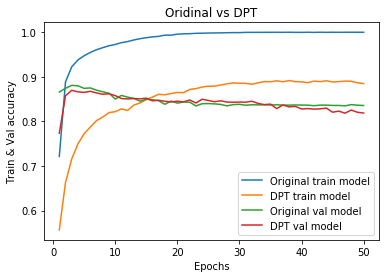

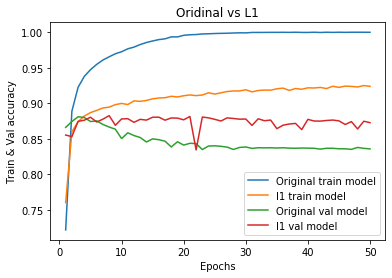

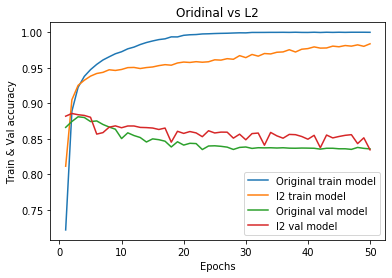

In [4]:
# Task 3: Plot the training and validation accuracy
import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(1, 51)
model_train_accuracy = model_hist.history['acc']
dpt_model_train_accuracy = dpt_model_hist.history['acc']
l1_model_hist_train_accuracy = l1_model_hist.history['acc']
l2_model_hist_train_accuracy = l2_model_hist.history['acc']

model_val_accuracy = model_hist.history['val_acc']
dpt_model_val_accuracy = dpt_model_hist.history['val_acc']
l1_model_hist_val_accuracy = l1_model_hist.history['val_acc']
l2_model_hist_val_accuracy = l2_model_hist.history['val_acc']

plt.plot(epochs, model_train_accuracy, label='Original train model')
plt.plot(epochs, dpt_model_train_accuracy, label='DPT train model')

plt.plot(epochs, model_val_accuracy, label='Original val model')
plt.plot(epochs, dpt_model_val_accuracy, label='DPT val model')

plt.title('Oridinal vs DPT')
plt.xlabel('Epochs')
plt.ylabel('Train & Val accuracy')
plt.legend()

plt.show()

plt.plot(epochs, model_train_accuracy, label='Original train model')
plt.plot(epochs, l1_model_hist_train_accuracy, label='l1 train model')

plt.plot(epochs, model_val_accuracy, label='Original val model')
plt.plot(epochs, l1_model_hist_val_accuracy, label='l1 val model')

plt.title('Oridinal vs L1')
plt.xlabel('Epochs')
plt.ylabel('Train & Val accuracy')
plt.legend()

plt.show()

plt.plot(epochs, model_train_accuracy, label='Original train model')
plt.plot(epochs, l2_model_hist_train_accuracy, label='l2 train model')

plt.plot(epochs, model_val_accuracy, label='Original val model')
plt.plot(epochs, l2_model_hist_val_accuracy, label='l2 val model')

plt.title('Oridinal vs L2')
plt.xlabel('Epochs')
plt.ylabel('Train & Val accuracy')
plt.legend()

plt.show()

# Task 4: Comments
DPT reduced overflowing but looking at the training accuracy, it start to slow down at 30 epochs and do not rise much after that. The DPT validation accuracy do not have much of a change.
For L1, the training accuracy rise at a stable rate, the validation accuracy is better than original but it is less stable, at epochs 22, there is a sudden drop of 0.05 accuracy.
For L2, the training accuracy is high and rising at a stable rate. The validation accuracy have increase a bit too.

To summary, DPT, L1 and L2 can help in overflowing but L1 and L2 do a better join as it improve the validation metric. But this also resulted in traning accuracy to drop, making it need more resurce(epochs) to get the data needed